# NPZD new prototype

- start building model and fluxes

For the first model example I will need:
- Forcing input
- Forcing_fluxes:
    - mixing
    - sinking
- 4 components (single) N, P, Z, D
- Fluxes:
TODO: GO OVER THE equations! Base model structure in math!
    - Grazing - linked to all NPZD
    - PhytoplanktonGrowth
        - Light - Dependence
        - Nutrients - Dependence
        - Temp - Dependence
    - mortality
    - remineralisation
    - higher order pred, etc
 

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# to measure process time
import time as tm

In [2]:
from xsimlab.monitoring import ProgressBar

In [3]:
import os,sys,inspect
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import phydra

In [4]:
from phydra.processes.statevars import SV, Time

from phydra.processes.forcings import ConstantForcing, SinusoidalForcing

from phydra.processes.fluxes import (LinearOutputFlux, ForcingLinearInputFlux, 
                                     MonodUptake, HollingTypeIIIGrazing,
                                    
                                    MultiLossTest, PartialOutputLossTest)

In [9]:
MultiTest = phydra.create({
    # SV
    'N':SV,
    'P':SV,
    'Q':SV,
    
    # Fluxes
    'N_loss':LinearOutputFlux,
    'MultiLoss':MultiLossTest,
    
    # Forcing
    'N_input':ForcingLinearInputFlux,
    'N0':ConstantForcing, #SinusoidalForcing
})

In [10]:
MultiTest

<xsimlab.Model (10 processes, 14 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
N
    init            [in]
P
    init            [in]
Q
    init            [in]
N0
    value           [in]
N_loss
    rate            [in] flowing rate
    sv              [in] state variable affected by flux
MultiLoss
    rate            [in] () or ('MultiLoss',) 
    sink            [in]
    sources         [in] ('MultiLoss',) 
N_input
    fx              [in] forcing affecting rate
    rate            [in] flowing rate
    sv              [in] state variable affected by forcing flux
Solver

In [11]:
odeint_setup = phydra.setup('odeint', MultiTest,
            time=np.arange(0,20,0.01),
            input_vars={
                'N__init':0.5,
                'P__init':0.5,
                'Q__init':0.7,
                
                'N_loss':{'sv':'N',
                          'rate':.01},
                'MultiLoss':{'sources':['N','P'],
                             'sink':'Q',
                            'rate':[.2,.1]},
                
                'N_input':{'fx':'N0',
                          'rate':0.5,
                          'sv':'N'},
                
                'N0':{'value':2},
                
            },
            output_vars={'N__value','P__value','Q__value'}
            )

In [12]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=MultiTest)


             0% | initialize 
███▎        33% | run step 0/1 
██████▋     67% | finalize     
██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Q
calling model context
initializing forcing N0
initializing flux N_loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_name': 'sink', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.INPUT: 'input'>, 'dims': [()], 'partial_out': 'sink_out', 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': [()]}], <FluxVarType.PARAMETER: 'parameter'>: [{'var_

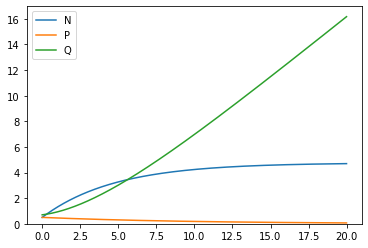

In [13]:
plt.plot(out_ds.Time__time, out_ds.N__value, label='N')
plt.plot(out_ds.Time__time, out_ds.P__value, label='P')
plt.plot(out_ds.Time__time, out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [14]:
gekko_setup = phydra.update_setup(model=MultiTest, old_setup=odeint_setup, new_solver="gekko")

In [15]:
stepwise_setup = phydra.update_setup(model=MultiTest, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [16]:
# stepwise_setup

and solve the model like this:

In [17]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=MultiTest)


             0% | initialize 
███▎        33% | run step 0/1 
██████▋     67% | finalize     
██████████ 100% | Simulation finished in 00:00 

initializing model core
Initializing Model Time
calling model context
initializing state variable N
calling model context
initializing state variable P
calling model context
initializing state variable Q
calling model context
initializing forcing N0
initializing flux N_loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_name': 'sink', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.INPUT: 'input'>, 'dims': [()], 'partial_out': 'sink_out', 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': [()]}], <FluxVarType.PARAMETER: 'parameter'>: [{'var_

In [18]:
# out_ds

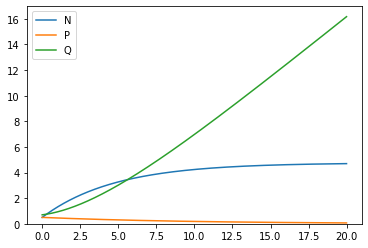

In [19]:
plt.plot(out_ds.Time__time, out_ds.N__value, label='N')
plt.plot(out_ds.Time__time, out_ds.P__value, label='P')
plt.plot(out_ds.Time__time, out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [20]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=MultiTest)


             0% | initialize 

initializing model core
Initializing Model Time
creating new SV StateVariable(name='time', initial_value=0.0, value=None, lb=0)
calling model context
initializing state variable N
creating new SV StateVariable(name='N', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable P
creating new SV StateVariable(name='P', initial_value=0.5, value=None, lb=0)
calling model context
initializing state variable Q
creating new SV StateVariable(name='Q', initial_value=0.7, value=None, lb=0)
calling model context
initializing forcing N0
initializing flux N_loss
initializing flux MultiLoss
 
flux_dict: 
defaultdict(<class 'list'>, {<FluxVarType.STATEVARIABLE: 'statevariable'>: [{'var_name': 'sources', 'metadata': {'var_type': <FluxVarType.STATEVARIABLE: 'statevariable'>, 'intent': <FluxVarIntent.IN: 'in'>, 'flow': <FluxVarFlow.OUTPUT: 'output'>, 'dims': 'MultiLoss', 'partial_out': None, 'sub_label': None, 'attrs': {}, 'description': ''}, 'dims': 'MultiLoss'}, {'var_nam


███▎        33% | run step 0/1 
██████▋     67% | run step 0/1 
██████▋     67% | finalize     
██████████ 100% | Simulation finished in 00:05 

Model was solved in 5.29 seconds
finalizing: cleanup


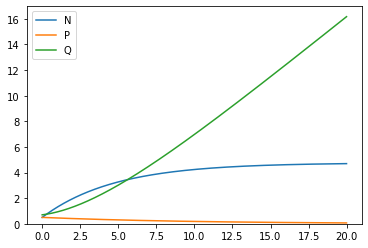

In [21]:
plt.plot(out_ds.Time__time, out_ds.N__value, label='N')
plt.plot(out_ds.Time__time, out_ds.P__value, label='P')
plt.plot(out_ds.Time__time, out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [ ]:
with ProgressBar(frontend="console"):
    out_ds2 = stepwise_setup.xsimlab.run(model=MultiTest)

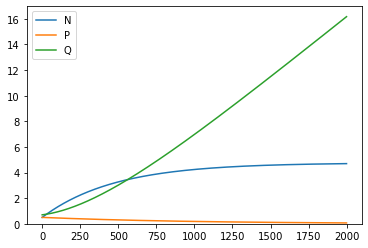

In [23]:
plt.plot(out_ds2.N__value, label='N')
plt.plot(out_ds2.P__value, label='P')
plt.plot(out_ds.Q__value, label='Q')
plt.ylim(bottom=0)
plt.legend()

In [20]:
# TODO

- allow input of list of svs
- 

SyntaxError: invalid syntax (<ipython-input-20-094865ff8d33>, line 3)

In [27]:
def functest1(a,b,c):
    return a + np.sum(b) - np.sum(c)


@np.vectorize
def functest(a,b,c):
    return b / functest1(a,b,c)

functest1(1,[2,4,2],[1,3,1])

4

In [26]:
np.sum(1)

1

In [20]:
NPZD = phydra.create({
    # SV
    'N':SV,
    'P':SV,
    'Z':SV,
    'D':SV,
    
    # Fluxes
    'N_loss':LinearOutputFlux,
    'P_loss':LinearOutputFlux,
    
    # Exchanges
    'Monod':MonodUptake,
    'Grazing':HollingTypeIIIGrazing,
    
    # Forcing
    'N_input':ForcingLinearInputFlux,
    'N0':ConstantForcing
})

In [21]:
NPZD

<xsimlab.Model (13 processes, 22 inputs)>
Core
    solver_type     [in]
Time
    time            [in] ('input_time',) A sequence of Time points ...
N
    init            [in]
P
    init            [in]
Z
    init            [in]
D
    init            [in]
N0
    value           [in]
N_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
P_loss
    sv              [in] state variable affected by flux
    rate            [in] flowing rate
Monod
    resource        [in]
    consumer        [in]
    halfsat         [in] half saturation constant
Grazing
    resource        [in]
    Imax            [in] maximum ingestion rate
    kZ              [in] feeding preferences
    consumer        [in]
    feed_pref       [in] feeding preferences
N_input
    fx              [in] forcing affecting rate
    sv              [in] state variable affected by forcing flux
    rate            [in] flowing rate
Solver

In [22]:
#Model.visualize(show_inputs=True)

In [23]:
odeint_setup = phydra.setup('odeint', NPZD,
            time=np.arange(0,20,0.1),
            input_vars={
                'N__init':0.5,
                'P__init':0.5,
                'Z__init':0.5,
                'D__init':0.5,
                
                'N_loss':{'sv':'N',
                          'rate':.01},
                
                'P_loss':{'sv':'P',
                          'rate':.5},
                
                'N_input':{'sv':'N',
                          'fx':'N0',
                          'rate':.1},
                
                'Monod':{'resource':'N',
                        'consumer':'P',
                        'halfsat':.5},
                
                'Grazing':{'resource':'P',
                        'consumer':'Z',
                        'feed_pref':1.,
                        'Imax':1.5,
                        'kZ':.7},
                
                'N0__value':2.,
            },
            output_vars={'N__value','P__value','Z__value','D__value'}
            )

In [24]:
gekko_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="gekko")

In [25]:
stepwise_setup = phydra.update_setup(model=NPZD, old_setup=odeint_setup, new_solver="stepwise")

 you can view the setup xarray (before solving) simply like this:

In [26]:
# stepwise_setup

and solve the model like this:

In [27]:
with ProgressBar(frontend="console"):
        out_ds = odeint_setup.xsimlab.run(model=NPZD)

             0% | initialize 

initializing model core
Initializing Model Time
initializing state variable N
initializing state variable P
initializing state variable Z
initializing state variable D
initializing forcing N0


AttributeError: 'ModelBackend' object has no attribute 'Param'

In [28]:
# out_ds

AttributeError: 'Dataset' object has no attribute 'Z__value'

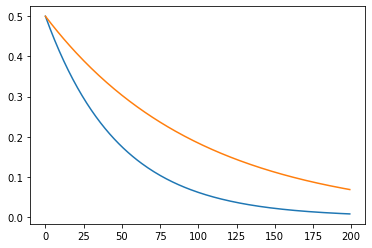

             0% | initialize 


In [29]:
plt.plot(out_ds.N__value, label='N')
plt.plot(out_ds.P__value, label='P')
plt.plot(out_ds.Z__value, label='Z')
plt.plot(out_ds.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [15]:
with ProgressBar(frontend="console"):
        out_ds1 = gekko_setup.xsimlab.run(model=NPZD)

             0% | initialize 

initializing model core
Initializing Model Time
creating new SV StateVariable(name='time', initial_value=0.0, value=None, lb=0)
initializing state variable N
creating new SV StateVariable(name='N', initial_value=0.5, value=None, lb=0)
initializing state variable P
creating new SV StateVariable(name='P', initial_value=0.5, value=None, lb=0)
initializing state variable Z
creating new SV StateVariable(name='Z', initial_value=0.5, value=None, lb=0)
initializing state variable D
creating new SV StateVariable(name='D', initial_value=0.5, value=None, lb=0)
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux Grazing
initializing flux N_input
assembling model
SOLVER : gekko
{'_remote': False, '_server': 'http://byu.apmonitor.com', 'options': <gekko.gk_global_options.GKGlobalOptions object at 0x158f60ac0>, '_id': 0, '_gui_open': False, '_constants': [], '_parameters': [], '_variables': [0.0, 0.5, 0.5, 0.5, 0.5], '_intermediates': []

██████████ 100% | Simulation finished in 00:00 

Model was solved in 0.34 seconds
finalizing: cleanup


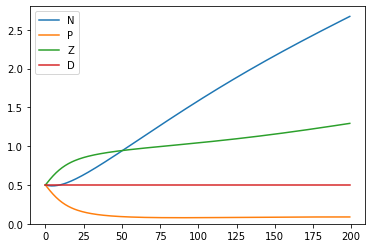

In [16]:
plt.plot(out_ds1.N__value, label='N')
plt.plot(out_ds1.P__value, label='P')
plt.plot(out_ds1.Z__value, label='Z')
plt.plot(out_ds1.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()

In [17]:
with ProgressBar(frontend="console"):
    out_ds2 = stepwise_setup.xsimlab.run(model=NPZD)

██████▎     63% | run step 126/199 

initializing model core
Initializing Model Time
initializing state variable N
initializing state variable P
initializing state variable Z
initializing state variable D
initializing forcing N0
initializing flux N_loss
initializing flux P_loss
initializing flux Monod
initializing flux Grazing
initializing flux N_input
assembling model
SOLVER : stepwise


██████████ 100% | Simulation finished in 00:00 


finalizing: cleanup


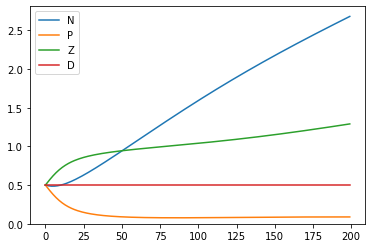

In [18]:
plt.plot(out_ds2.N__value, label='N')
plt.plot(out_ds2.P__value, label='P')
plt.plot(out_ds2.Z__value, label='Z')
plt.plot(out_ds2.D__value, label='D')
plt.ylim(bottom=0)
plt.legend()